# 0.0 IMPORTS

In [4]:
# Importing libs

import pandas as pd
import numpy  as np
import warnings 

from datetime import datetime

import seaborn           as sns
import matplotlib.pyplot as plt

from IPython.display       import Image
from IPython.core.display  import HTML

warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [5]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 10]

    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

In [6]:
jupyter_settings()

## 0.2 Loading Data

In [7]:
df_raw = pd.read_csv('heart.csv')

In [8]:
df_raw.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# 1.0 DATA DESCRIBE

In [9]:
df1 = df_raw.copy()

## 1.1 Data Dimensions

In [11]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 918
Number of columns: 12


## 1.2 Data types

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## 1.3 Check NA (%)

In [13]:
df_na = df1.isna().sum().sort_values(ascending=False)/df1.shape[0]*100
df_na

Age               0.0
Sex               0.0
ChestPainType     0.0
RestingBP         0.0
Cholesterol       0.0
FastingBS         0.0
RestingECG        0.0
MaxHR             0.0
ExerciseAngina    0.0
Oldpeak           0.0
ST_Slope          0.0
HeartDisease      0.0
dtype: float64

## 1.4 Check Duplicates

In [17]:
df1.duplicated().sum()

0

## 1.5 Analisys columns

In [19]:
df1.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

# 2.0 EXPLORATORY ANALISYS - EDA

In [27]:
df2 = df1.copy()

In [28]:
num_attributes = df2.select_dtypes(include=['int64', 'float64'])
cat_attributes = df2.select_dtypes(exclude=['int64', 'float64'])

## 2.1 Statistic analisys

### 2.1.1 Response Variable

In [181]:
df2['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

### 2.1.2 Numerical Variable

In [29]:
# Tendência central - média e mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - desvio padrão, min, max, assimetria, curtose
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Age,28.0,77.0,49.0,53.510893,54.0,9.427478,-0.195933,-0.386140
1,RestingBP,0.0,200.0,200.0,132.396514,130.0,18.504067,0.179839,3.271251
2,Cholesterol,0.0,603.0,603.0,198.799564,223.0,109.324551,-0.610086,0.118208
3,FastingBS,0.0,1.0,1.0,0.233115,0.0,0.422815,1.264484,-0.401960
4,MaxHR,60.0,202.0,142.0,136.809368,138.0,25.446463,-0.144359,-0.448248
5,Oldpeak,-2.6,6.2,8.8,0.887364,0.6,1.065989,1.022872,1.203064
6,HeartDisease,0.0,1.0,1.0,0.553377,1.0,0.497143,-0.215086,-1.958008


<Axes: >

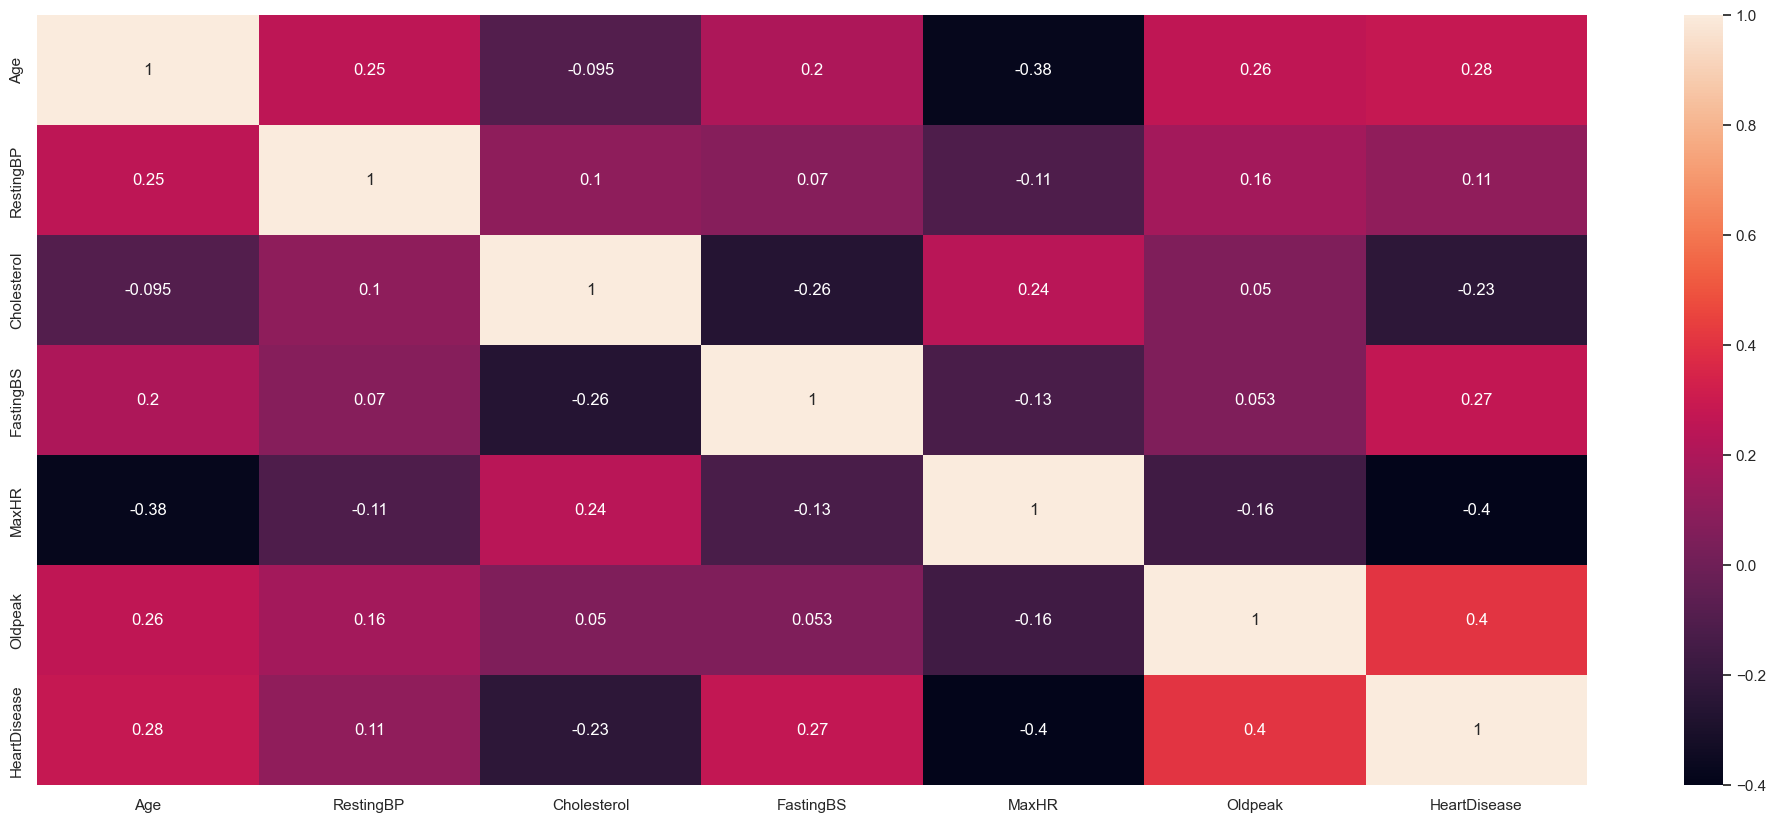

In [183]:
sns.heatmap(data=df2.corr(), annot=True);

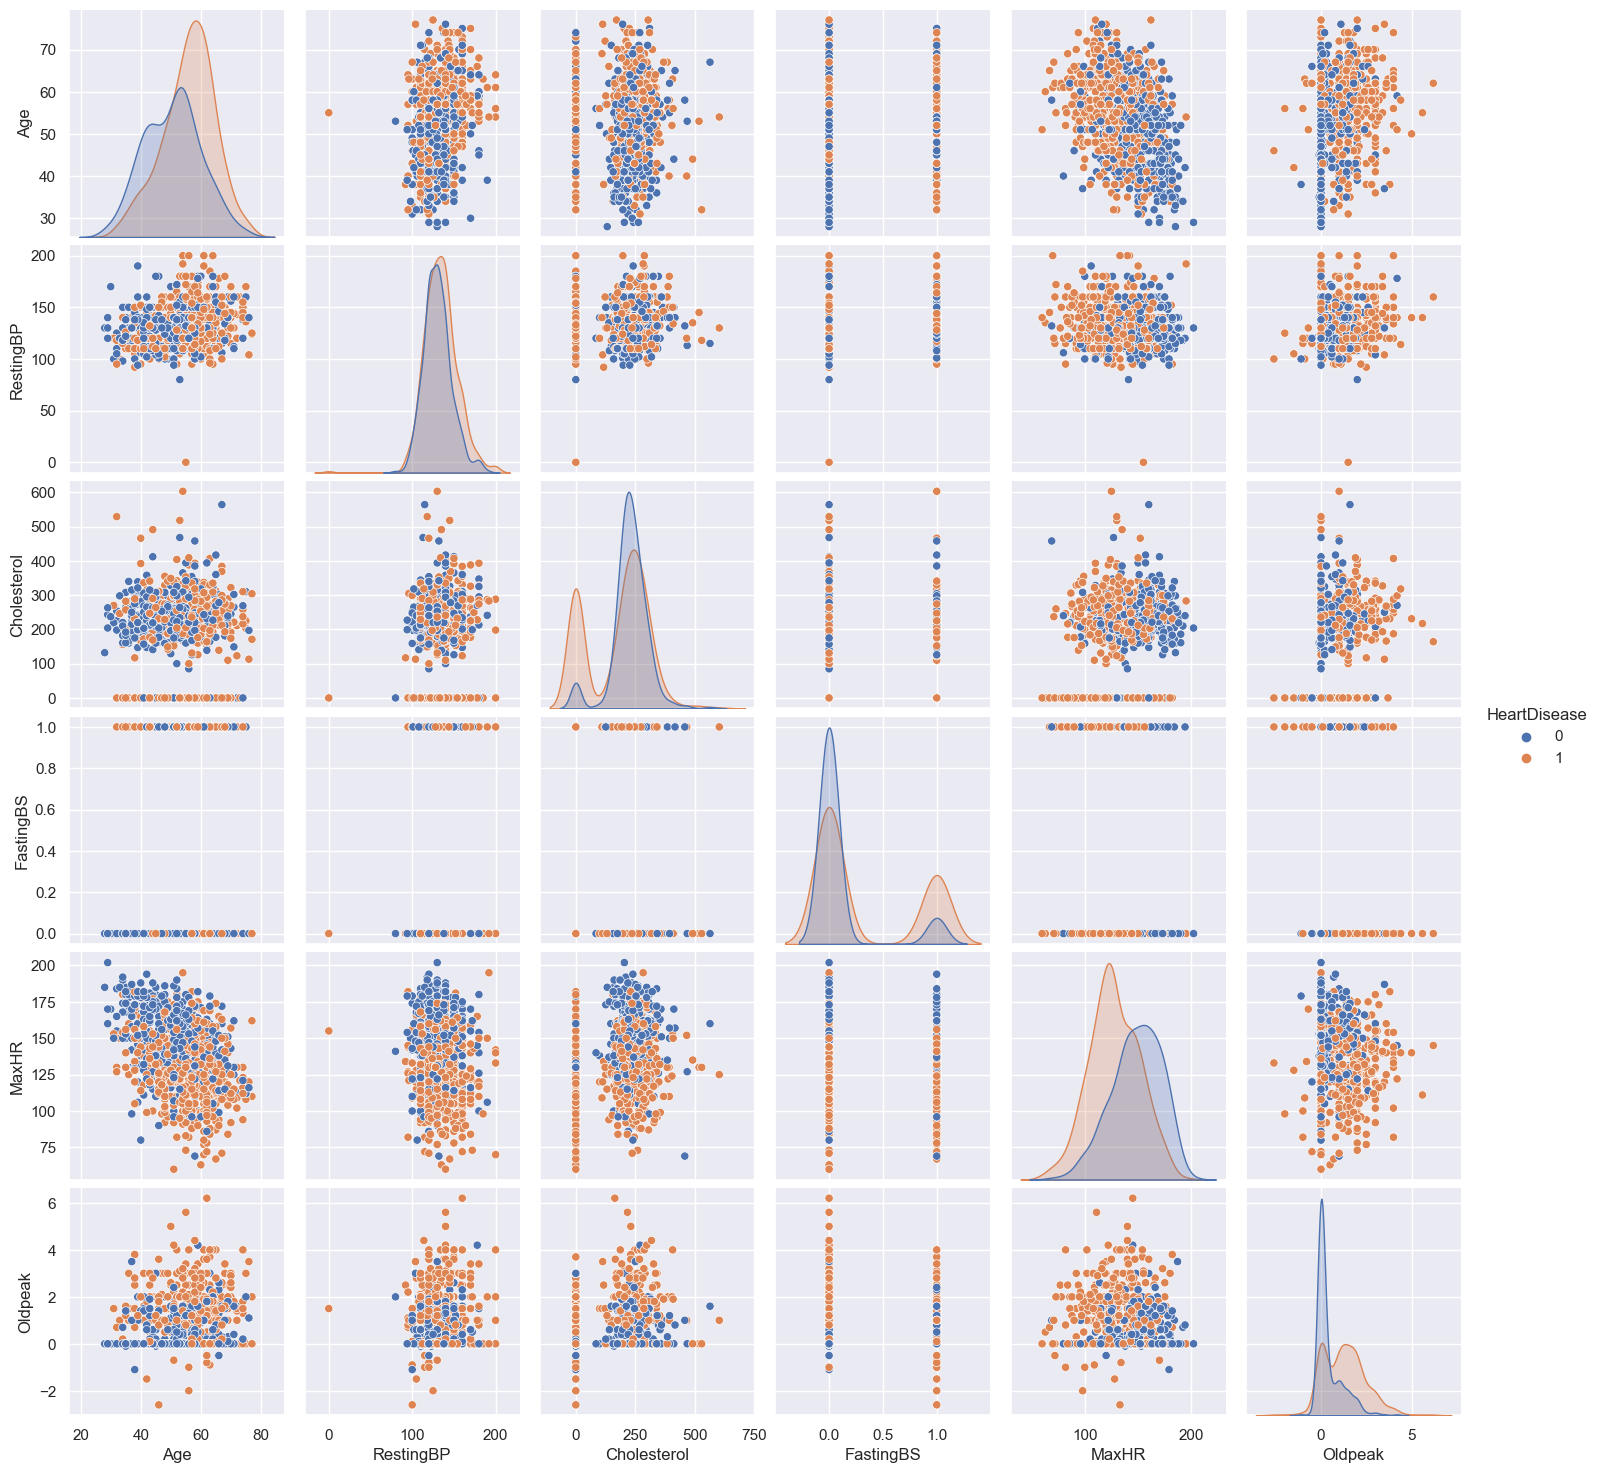

In [187]:
sns.pairplot(df2, hue='HeartDisease');

## 2.2 Categorys analisys

### 2.2.1 Age distribution by sex

In [30]:
cat_attributes.columns

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')

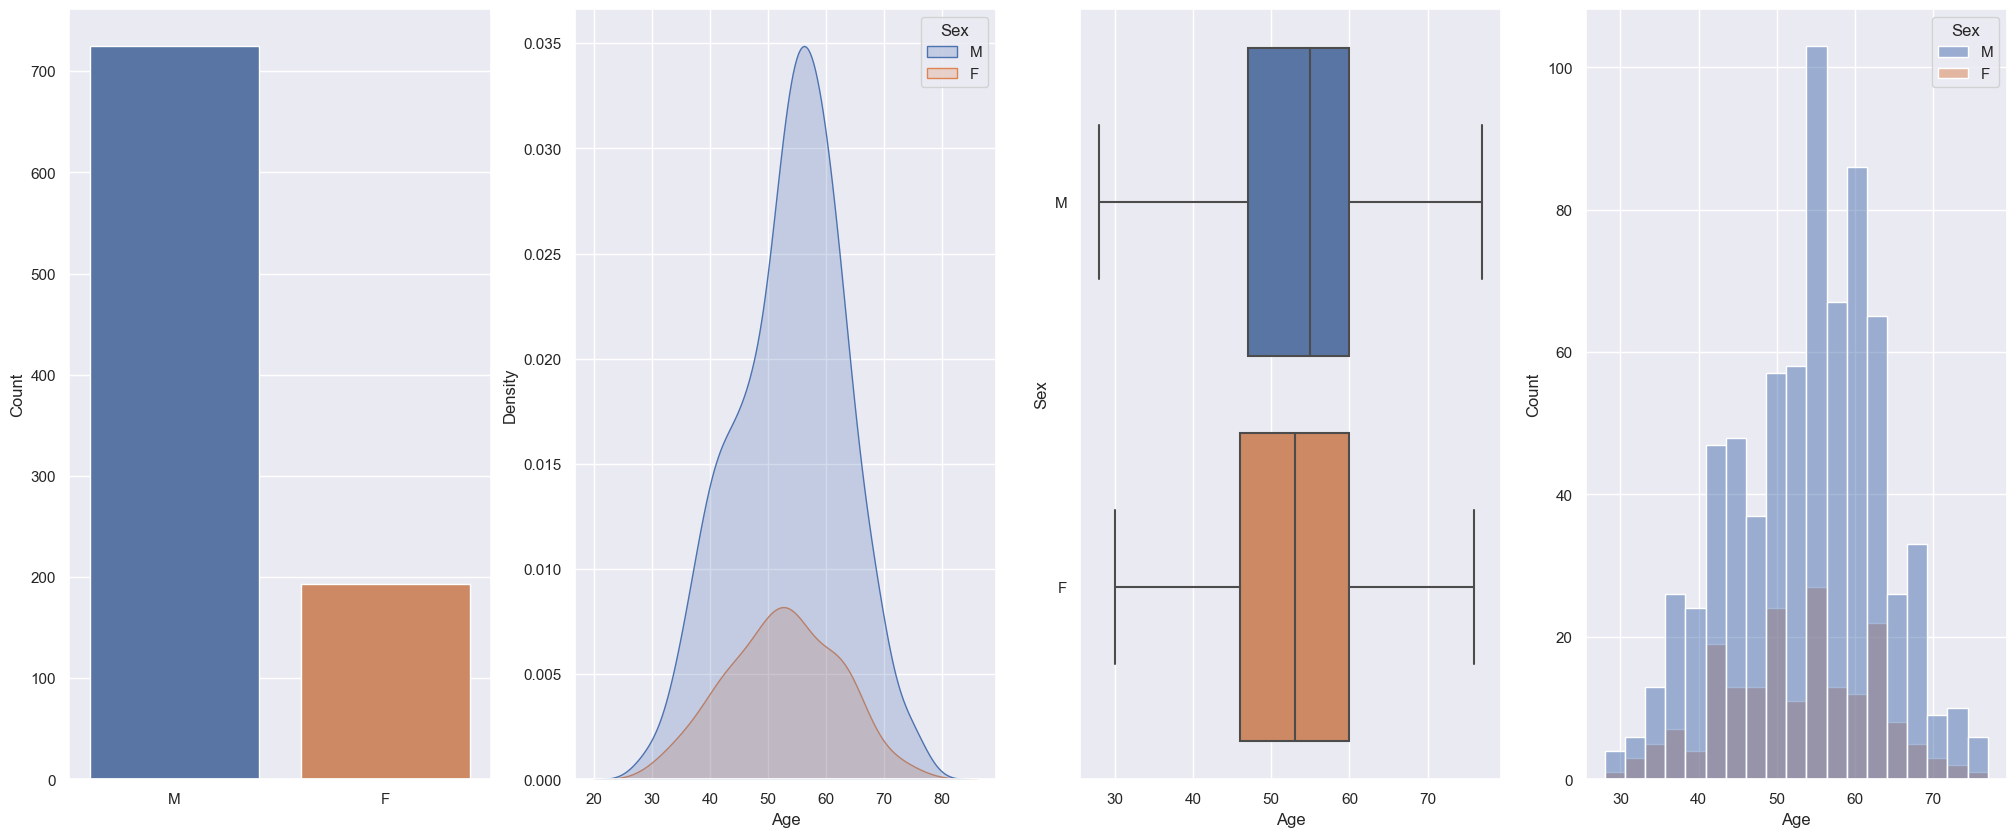

In [204]:
plt.subplot(1, 4, 1)
aux = df2['Sex'].value_counts()
sns.barplot(x=aux.index, y=aux)
plt.ylabel('Count');

plt.subplot(1, 4, 2)
sns.kdeplot(data=df2, x='Age', hue='Sex', shade=True);

plt.subplot(1, 4, 3)
sns.boxplot(y='Sex', x='Age', data=df2);

plt.subplot(1, 4, 4)
sns.histplot(x=df2['Age'], hue=df2['Sex']);

### 2.2. Chest Pain Type by Sex

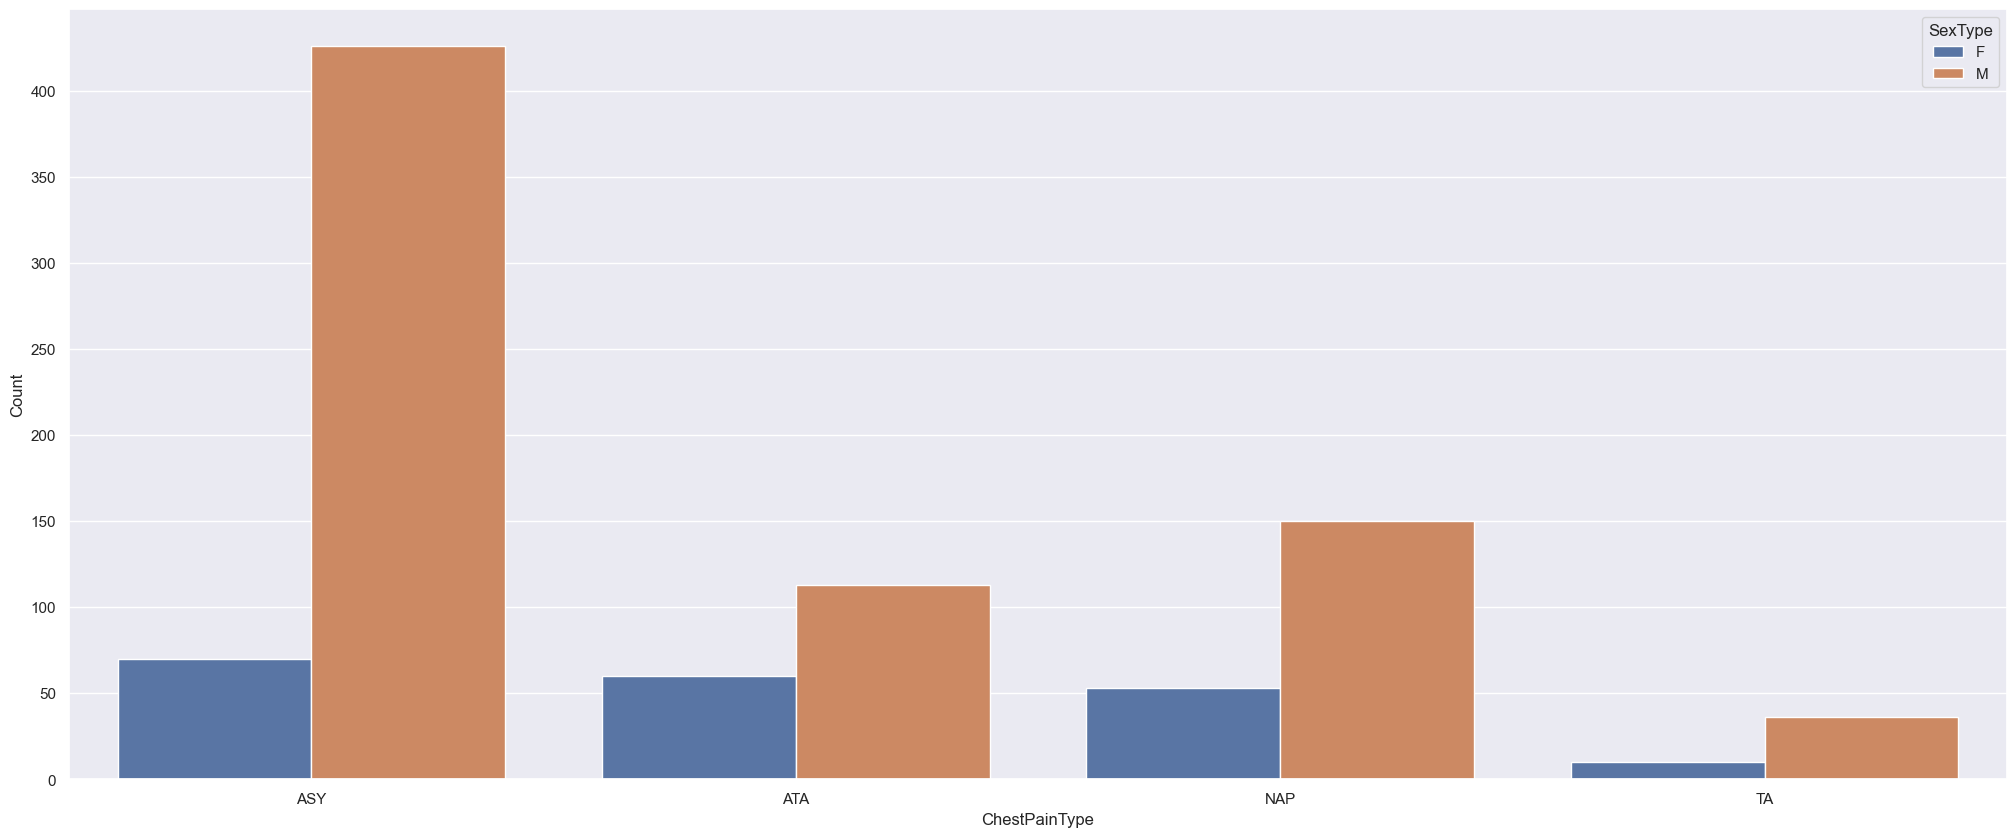

In [159]:
graph1 = pd.DataFrame(df2.groupby(['ChestPainType', 'Sex'])['Sex'].count()).reset_index(names=['ChestPainType', 'SexType'])
graph1
sns.barplot(x='ChestPainType', y='Sex', hue='SexType', data=graph1)
plt.ylabel('Count');

### 2.2.3 Max Heart Rate (MaxHR) relations

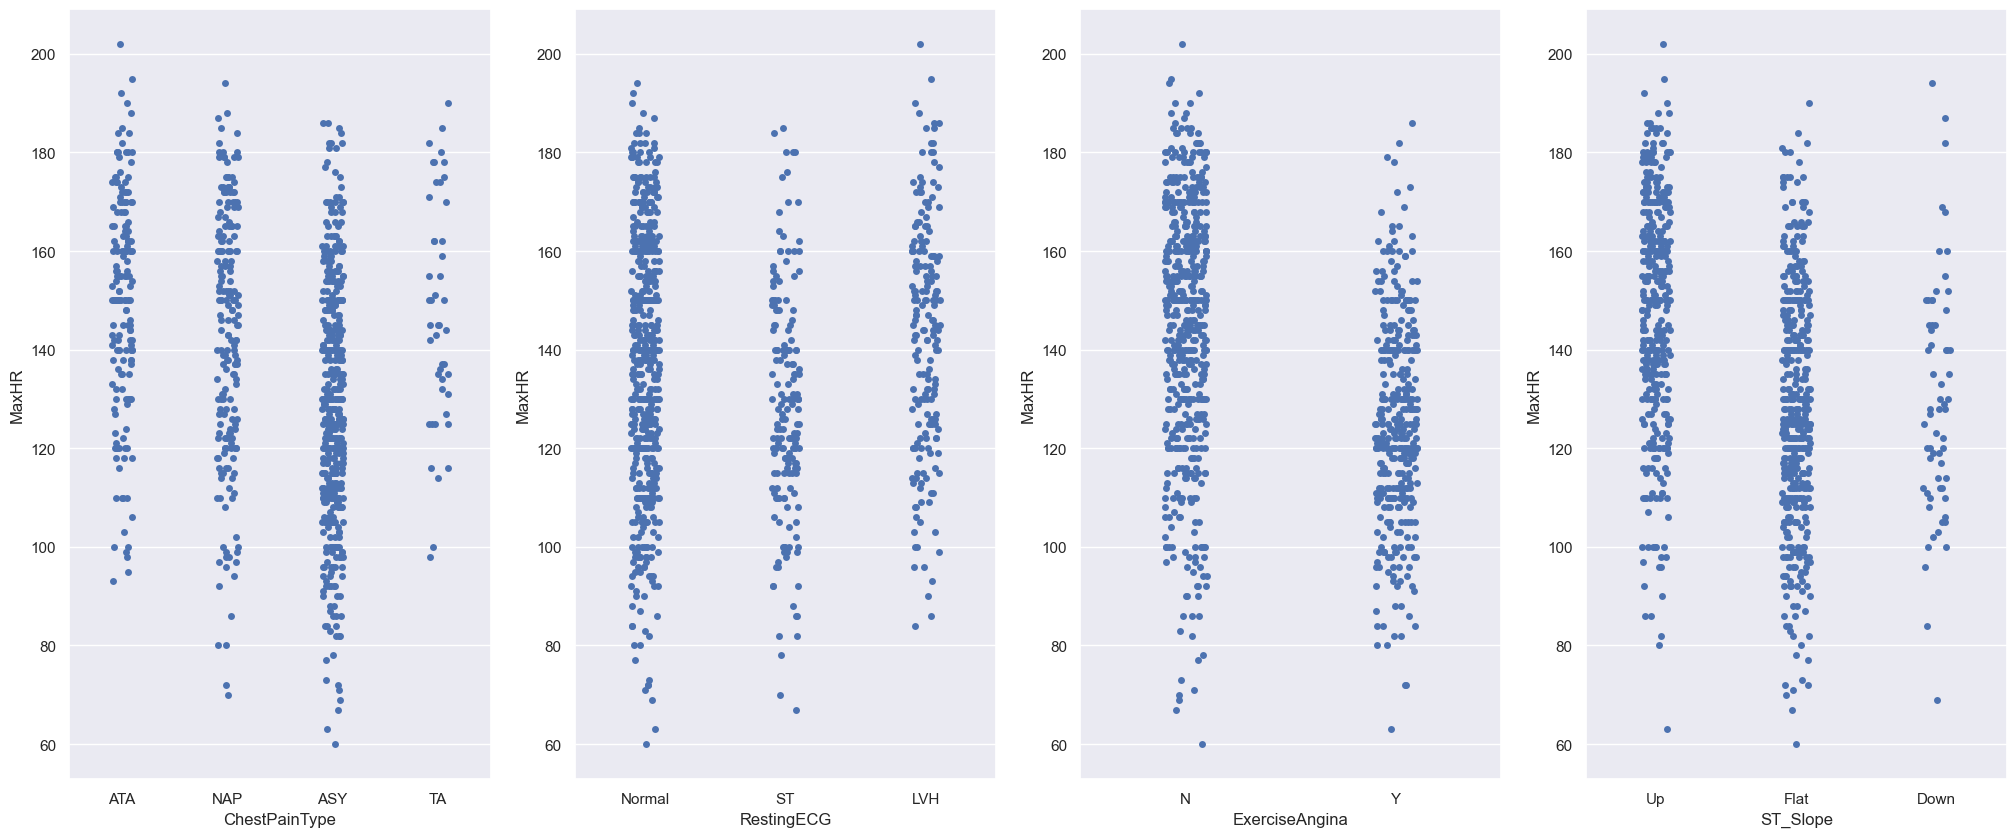

In [212]:
graph2 = df2[['ChestPainType', 'MaxHR']]
plt.subplot(1, 4, 1)
sns.stripplot(x='ChestPainType', y='MaxHR', data=graph2);

graph3 = df2[['RestingECG', 'MaxHR']]
plt.subplot(1, 4, 2)
sns.stripplot(x='RestingECG', y='MaxHR', data=graph3);

graph4 = df2[['ExerciseAngina', 'MaxHR']]
plt.subplot(1, 4, 3)
sns.stripplot(x='ExerciseAngina', y='MaxHR', data=graph4);

graph5 = df2[['ST_Slope', 'MaxHR']]
plt.subplot(1, 4, 4)
sns.stripplot(x='ST_Slope', y='MaxHR', data=graph5);

### 2.2.4 Chest Pain Type e Resting ECG analysis

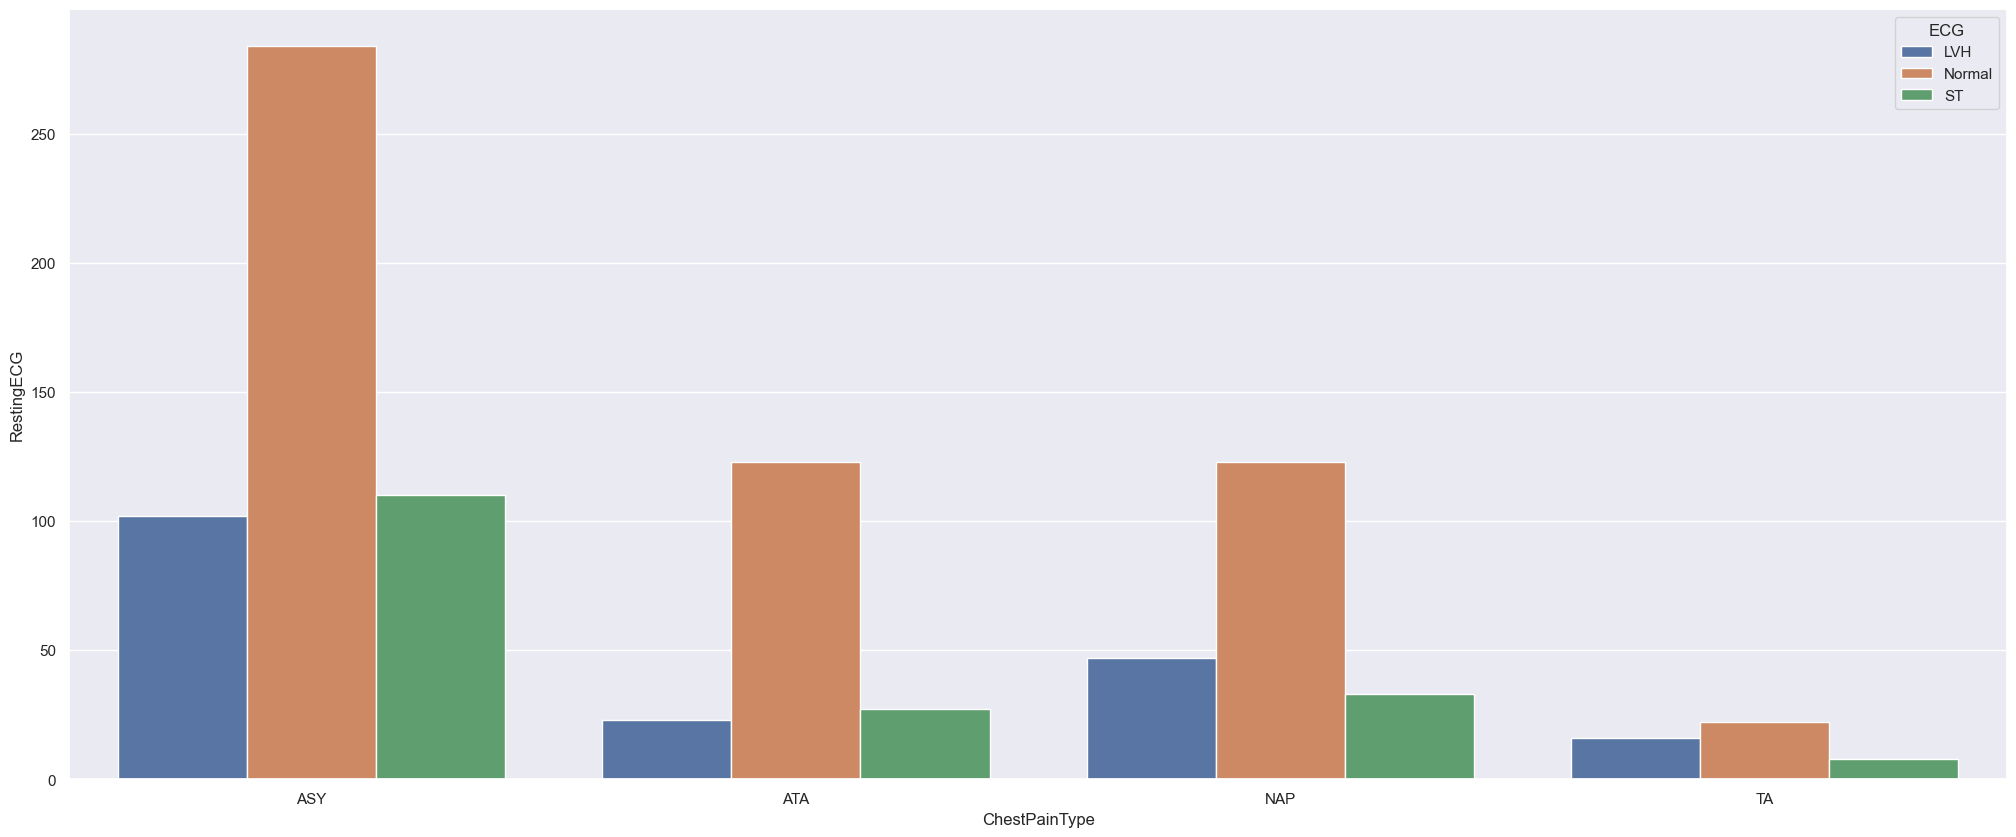

In [209]:
graph6 = pd.DataFrame(df2[['ChestPainType', 'RestingECG']].groupby(['ChestPainType', 'RestingECG'])['RestingECG'].count()).reset_index(names=['ChestPainType', 'ECG'])
sns.barplot(x='ChestPainType', y='RestingECG', hue='ECG', data=graph6);